# Traffic Light Control Simulation

We are simulating traffic flow of a simplified Silom-Sathorn intersection network for 1 hour. The performance metric is average velocity of all cars in the scenario averaged across all timesteps (1 second per timestep). We demonstrated that by using an **actuated control logic** (switches the lights when a significant gap is presented among vehicles) as opposed to static control logic (switches the lights every fixed interval regardless of traffic conditions). We can see that using actuated control can **increase average velocity of all vehicles across all timesteps by 34%.**

In [20]:
from flow.scenarios.grid import SimpleGridScenario
from flow.core.params import NetParams, TrafficLightParams, SumoParams, EnvParams, InitialConfig, NetParams, SumoCarFollowingParams
from flow.core.params import VehicleParams
from flow.controllers.car_following_models import IDMController
from flow.controllers.routing_controllers import ContinuousRouter
import numpy as np
import pandas as pd
from plotnine import *
import pickle
import warnings
warnings.filterwarnings('ignore')

In [24]:
static = pickle.load(open('data/static.pkl','rb'))['velocities'][0]
actuated  = pickle.load(open('data/actuated.pkl','rb'))['velocities'][0]
df = pd.DataFrame({'seconds':range(3600),'static':static,'actuated':actuated})[['seconds','static','actuated']]
df.describe()

,seconds,static,actuated
count,3600.000000,3600.000000,3600.000000
mean,1799.500000,5.573036,8.446148
std,1039.374812,0.762568,2.480226
min,0.000000,1.388174,1.388174
25%,899.750000,5.183605,6.285216
50%,1799.500000,5.388490,9.246599
75%,2699.250000,5.758721,10.401787
max,3599.000000,12.007670,12.030301


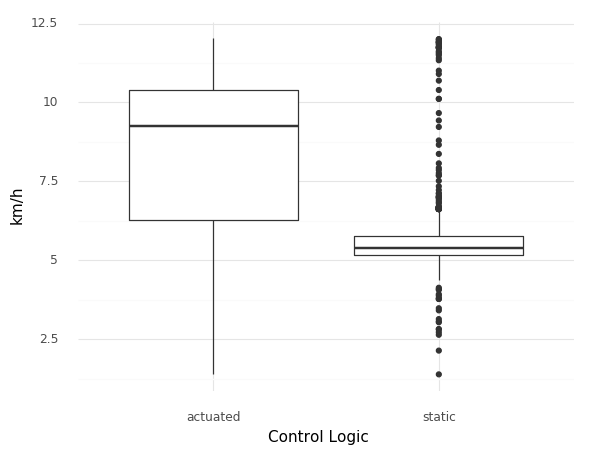

<ggplot: (-9223363276854493766)>

In [35]:
df_m = df.melt(id_vars='seconds')
g = (ggplot(df_m,aes(x='variable',y='value')) + geom_boxplot() + theme_minimal() +
     geom_smooth() + ylab('km/h') + xlab('Control Logic')
    )
g

## Grid Setup

From the intersection network below, we formulated a 2-by-3 simple traffic grid with cars coming in from all directions.

![Silom-Sathorn Intersection Network](img/silom.PNG)

In [2]:
#set up grid
inner_length = 300
long_length = 500
short_length = 300
n = 2 # rows
m = 3 # columns
num_cars_left = 20
num_cars_right = 20
num_cars_top = 20
num_cars_bot = 20
enter_v = 30
horizon=60 * 60
tot_cars = (num_cars_left + num_cars_right) * m + (num_cars_top + num_cars_bot) * n

grid_array = {"short_length": short_length, "inner_length": inner_length,
              "long_length": long_length, "row_num": n, "col_num": m,
              "cars_left": num_cars_left, "cars_right": num_cars_right,
              "cars_top": num_cars_top, "cars_bot": num_cars_bot}

#initial parameter
additional_init_params = {'enter_speed': enter_v}
initial_params = InitialConfig(
    spacing='custom', additional_params=additional_init_params)

## Traffic Light Control Logic

There are two types traffic light control logic provided by the [SUMO simulation](https://sourceforge.net/projects/sumo/) in [Flow](http://localhost:8888/notebooks/flow/tutorials/tutorial11_traffic_lights.ipynb) that we use:
1. Static Control: *static traffic lights are traffic lights with pre-defined phases. They cannot dynamically adjust according to traffic needs; they simply follow the same pattern repeatedly.*
2. Actuated Control: *This control scheme is common in Germany and works by prolonging traffic phases whenever a continuous stream of traffic is detected. It switches to the next phase after detecting a sufficent time gap between sucessive vehicles. This allows for better distribution of green-time among phases and also affects cycle duration in response to dynamic traffic conditions*

In [3]:
#traffic lights
tl_logic = TrafficLightParams()
nodes = ["center0", "center1", "center2", "center3", "center4", "center5"]
# #static
# phases = [{"duration": "31", "state": "GrGr"},
#           {"duration": "6", "state": "yryr"},
#           {"duration": "31", "state": "rGrG"},
#           {"duration": "6", "state": "ryry"}]
# for node_id in nodes:
#     tl_logic.add(node_id, tls_type="static", programID="1", offset=None, phases=phases)

#actuated
phases = [{"duration": "31", "minDur": "8", "maxDur": "45", "state": "GrGr"},
          {"duration": "6", "minDur": "3", "maxDur": "6", "state": "yryr"},
          {"duration": "31", "minDur": "8", "maxDur": "45", "state": "rGrG"},
          {"duration": "6", "minDur": "3", "maxDur": "6", "state": "ryry"}]
for node_id in nodes:
    tl_logic.add(node_id,              
            tls_type="actuated", 
             programID="1", 
             phases=phases, 
             maxGap=5.0, 
             detectorGap=0.9, 
             showDetectors=False)

In [4]:
#network parameters
additional_net_params = {"grid_array": grid_array, "speed_limit": 100,
                         "horizontal_lanes": 1, "vertical_lanes": 1,
                         "traffic_lights": True, "tl_logic": tl_logic}
net_params = NetParams(no_internal_links=False,
                       additional_params=additional_net_params)

## Other Setups

We also need to setup the routing for vehicles in the simulation, as well as simulation and environment parameters.

In [5]:
#vehicles
from flow.controllers import SimCarFollowingController, GridRouter
vehicles = VehicleParams()
vehicles.add(
    veh_id='idm',
    acceleration_controller=(SimCarFollowingController, {}),
    car_following_params=SumoCarFollowingParams(
        min_gap=2.5,
        decel=7.5,  # avoid collisions at emergency stops
        max_speed=enter_v,
        speed_mode="all_checks",
    ),
    routing_controller=(GridRouter, {}),
    num_vehicles=tot_cars)

In [6]:
#sumo simulation parameter
from flow.core.params import SumoParams
sumo_params = SumoParams(sim_step=1, render=True, emission_path='data') #1 sec for step

In [7]:
#environment parameter
from flow.core.params import EnvParams
additional_env_params = {
        'target_velocity': 50,
        'switch_time': 3.0,
        'num_observed': 2,
        'discrete': False,
        'tl_type': 'actuated'} #actuated or controlled (rl)
env_params = EnvParams(horizon=horizon, additional_params=additional_env_params)

## Experiment

We run the experiment based on the abovementioned scenario for 1 hour and calculate the average velocity of all vehicles across all timesteps as our performance metric.

![](img/sbooster_intersection.png)
![](img/sbooster_network.png)

In [8]:
#run experiment
from flow.envs.green_wave_env import TrafficLightGridEnv
from flow.core.experiment import Experiment

#scenario
scenario = SimpleGridScenario(name="grid",
                              vehicles=vehicles,
                              net_params=net_params,
                              initial_config=initial_params,
                              traffic_lights=tl_logic)
env = TrafficLightGridEnv(env_params, sumo_params, scenario)

# create the experiment object
exp = Experiment(env)

# run the experiment for a set number of rollouts / time steps
result = exp.run(1, horizon, rl_actions=lambda state: 0)

Round 0, return: -3399.3707144278283
Average, std return: -3399.3707144278283, 0.0
Average, std speed: 5.573035654033489, 0.0


In [9]:
result['velocities'][0].mean()

5.573035654033489

In [11]:
# import pickle
# with open('data/actuated.pkl', 'wb') as handle:
#     pickle.dump(result, handle, protocol=pickle.HIGHEST_PROTOCOL)